In [174]:
import bidict
import collections
import dataclasses
import functools
import itertools
import gensim
import nltk
import requests
import smart_open
import spacy
import string

In [9]:
# def mkdir(path, error_if_exists=False):
#     !mkdir {"-p" if not error_if_exists else ""} {path}
            
# def write_url_response_content_to_file(url: str, filename: str) -> None:
#     download_response = requests.get(url)
#     with open(filename, "wb") as f:
#         f.write(download_response.content)

In [63]:
@dataclasses.dataclass(frozen=True)
class DocumentMetaData:
    name: str
    path: str

    @functools.cache
    def read(self) -> str:
        return smart_open.open(self.path).read()


@dataclasses.dataclass(frozen=True)
class Config:
    documents: tuple[DocumentMetaData] = (
        DocumentMetaData(
            "apache_license", path="https://www.apache.org/licenses/LICENSE-2.0.txt"
        ),
        DocumentMetaData(
            "apple_agreement",
            path=(
                "https://raw.githubusercontent.com/nicwise/apple-agreements"
                "/fa5f05a60941be11349bc7fa2b6bb6d9b31eeaad/registered-apple-developer.txt"
            ),
        ),
        DocumentMetaData(
            "dracula", path="https://www.gutenberg.org/cache/epub/345/pg345.txt"
        ),
    )

In [161]:
def get_universal_tag(word: str) -> str:
    return nltk.tag.pos_tag([word], tagset="universal")[0][1]

def get_universal_tagset() -> bidict.bidict[str, str]:
    return bidict.bidict({
        "ADJ": "adjective",
        "ADP": "adposition",
        "ADV": "adverb",
        "CONJ": "conjunction",
        "DET": "determiner,",
        "NOUN": "noun",
        "NUM": "numeral",
        "PRT": "particle",
        "PRON": "pronoun",
        "VERB": "verb",
        ".": "punctuation",
        "X": "other",
    })

In [285]:
text = Config.documents[2].read()
text = text.lower()
text = text.translate({ord(p): None for p in string.punctuation})

tokens = nltk.tokenize.RegexpTokenizer("\w+").tokenize(text)
stopwords = set(nltk.corpus.stopwords.words("english"))
lemmatizer = nltk.stem.WordNetLemmatizer().lemmatize
tokens = [t for t in tokens if t not in stopwords and lemmatizer(t) not in stopwords]

tagged_tokens = nltk.tag.pos_tag(tokens, tagset="universal")

nltk_text = nltk.text.Text(tokens)

Most common tokens: said, one, could, us, must

Most common nouns: time, van, lucy, man, mina

Most common adjectives: good, much, poor, old, great

Most common verbs: said, could, must, would, shall

Most common adpositions: like, though, without, upon, since

Most common adverbs: back, even, well, away, yet

Most common phrases:
	van helsing; project gutenberg; madam mina; lord godalming; mrs
harker; friend john; could see; seward diary; harker journal; last
night; czarina catherine; united states; miss lucy; literary archive;
quincey morris; poor dear; jonathan harker; electronic works; archive
foundation; gutenberg electronic

Context for word 'castle':
	Displaying 10 of 50 matches:
ight map work giving exact locality castle dracula maps country yet compare or
w count dracula could tell anything castle wife crossed saying knew nothing si
ulling horses courtyard vast ruined castle whose tall black windows came ray l
n servant anywhere heard sound near castle except howling wolves ti

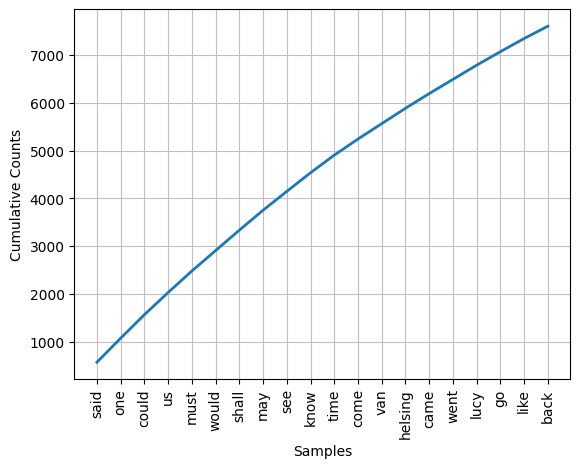

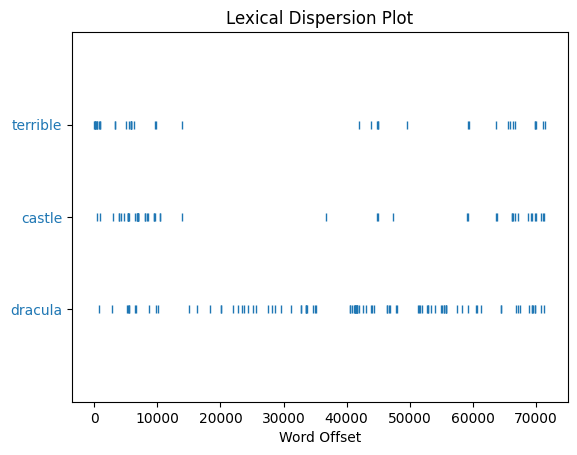

In [289]:
most_common_tokens = [tc[0] for tc in nltk_text.vocab().most_common(n=5)]

concordance_word = "castle"
similar_word = "terrible" 

print(f"Most common tokens: {', '.join(most_common_tokens)}\n")
for part_of_speech in ["noun", "adjective", "verb", "adposition", "adverb"]:
    tag = get_universal_tagset().inverse[part_of_speech]
    most_common_pos = itertools.islice(
        (tc[0] for tc in nltk_text.vocab().most_common() if get_universal_tag(tc[0]) == tag),
        5,
    )
    print(f"Most common {part_of_speech}s: {', '.join(most_common_pos)}\n")
    
print(f"Most common phrases:", end="\n\t")
nltk_text.collocations()
print(f"\nContext for word '{concordance_word}':", end="\n\t")
nltk_text.concordance(contextualized_word, lines=10)
print(f"\nTokens with context similar to '{similar_word}':", end="\n\t")
nltk_text.similar(similar_word)
nltk_text.vocab().plot(20, cumulative=True)
nltk_text.dispersion_plot(["dracula", "castle", "terrible"])

In [301]:
# Take some corpus, try gensim models on it (topic modeling, similarity queries)
# Spacy
# Write my own word2vec via pytorch (try torch.compile), lightning, annoy(faiss) libraries
# Create interactive questions such as which is most similar? Which is out of place?